# Exploring NFC signal recordings

In [1]:
import numpy as np
import scipy
from scipy import signal as sig
from matplotlib import pyplot as plt
import os

from signal_processing import complex_to_mag, shift_down, binary_slicer

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)

## File naming

Describe the file names and what they tell us...

- nfc as extension
- specify sample rate, usb standard, antenna, bandwidth, length... ?

In [2]:
PATH = "../data/raw/airspyhf+"

In [3]:
files = [file for file in os.listdir(PATH) if file.endswith(".nfc") and "test" in file]
files.sort()
files

['test-tag1.nfc',
 'test-tag2.nfc',
 'test-tag3.nfc',
 'test-taoglas-AirspyHF+-2M.nfc']

## Parse file

To parse the file, several element must be taken into account. First, the type of the data in the binary file. Here, we recorded our data as `complex64` values, so we must read them as such as well.

Second, the same sample rate used to record the signal must be used here as well.

In [4]:
samp_rate = int(2e6)
nfft = 1024

# The number of samples per period is equal to the sample rate divided by the frequency
print(samp_rate / 13.56e6)
print(847500 / 13.56e6)  # 1/16 might be interesting

0.14749262536873156
0.0625


In [5]:
signals = []

for file in files:
    signal = np.fromfile(os.path.join(PATH, file), dtype=scipy.complex64)
    name = file[:-4]
    signals.append((name, signal))

## Visualize

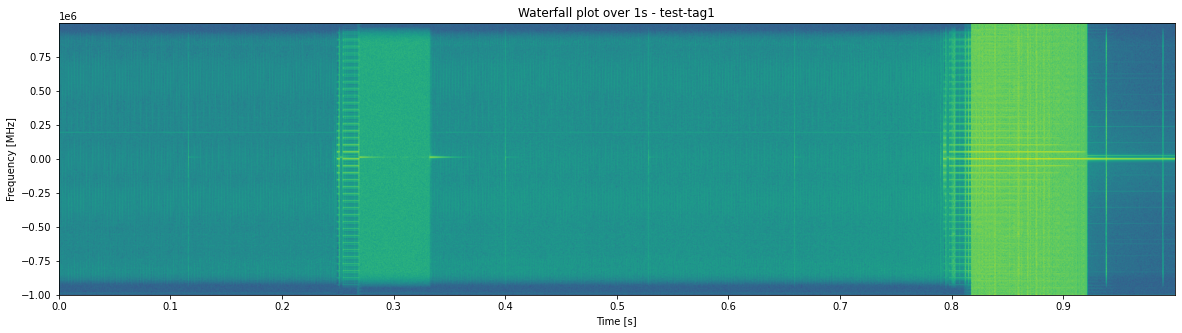

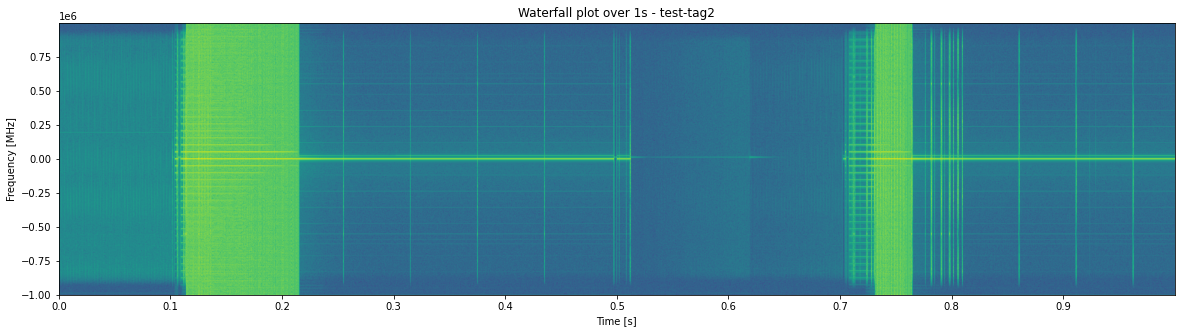

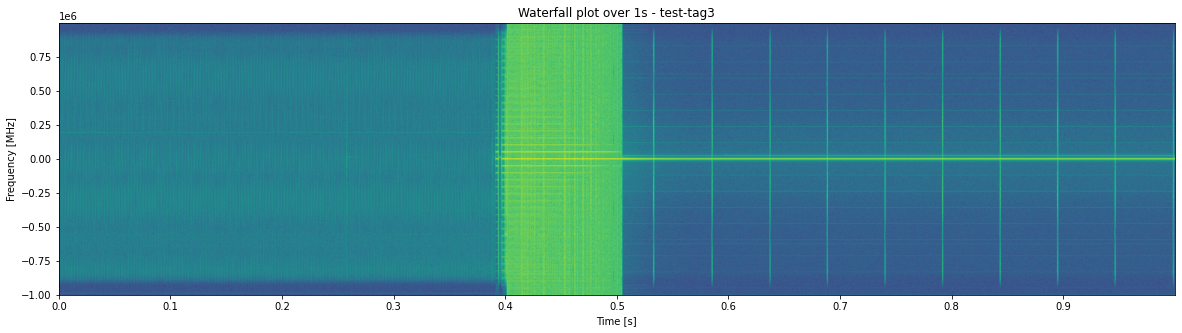

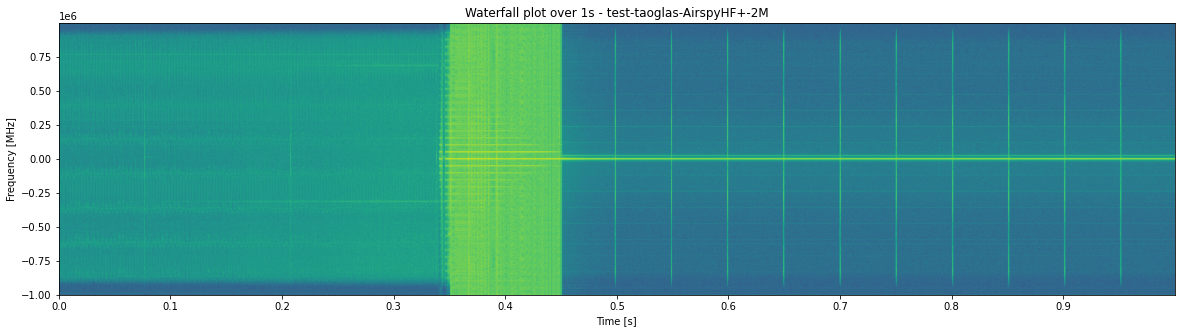

In [12]:
for signal in signals:
    plt.specgram(signal[1][int(samp_rate):int(2*samp_rate)], NFFT=nfft, Fs=samp_rate)
    plt.title("Waterfall plot over 1s - {}".format(signal[0]))
    plt.xlabel("Time [s]")
    plt.xticks(list(np.arange(0, 1, 0.1)))
    plt.ylabel("Frequency [MHz]")
    plt.show()

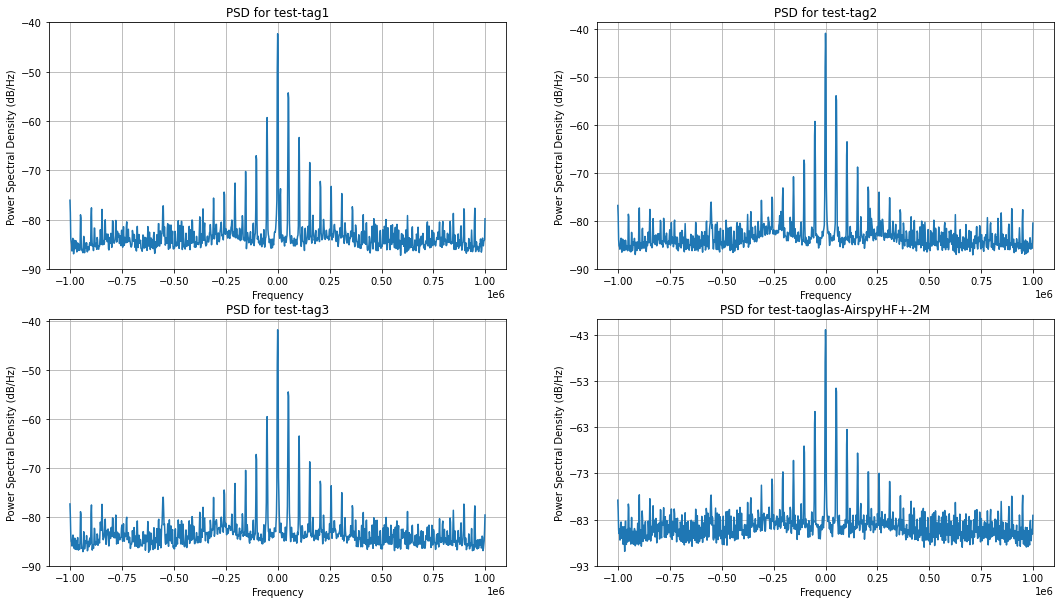

In [33]:
wh = int(len(signals)/2)
fig, axs = plt.subplots(wh, wh, figsize=(18, 10))

for signal, ax in (t for t in zip(signals, axs.flat)):
    ax.psd(signal[1][int(samp_rate):int(2*samp_rate)], NFFT=nfft, Fs=samp_rate)
    ax.set_title("PSD for {}".format(signal[0]))

---

## Explore the artifacts we noticed

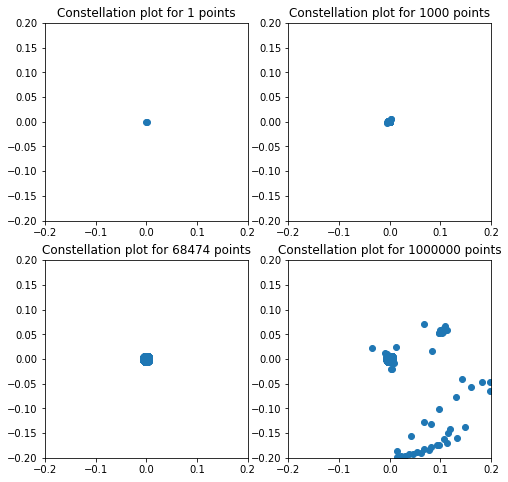

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

nbr_points = [1, 1000, 68474, 1000000]

for i, ax in (t for t in zip(nbr_points, axs.flat)):
    ax.axis([-0.2, 0.2, -0.2, 0.2])
    ax.scatter(np.real(data[0:i]), np.imag(data[0:i]))
    ax.set_title("Constellation plot for {} points".format(i))

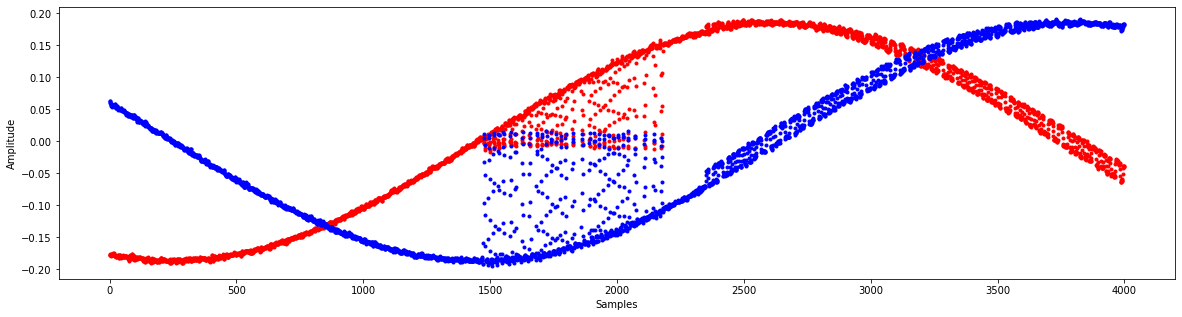

In [63]:
start = 67000
end = 71000

plt.plot(np.real(data[start:end]), 'r.', np.imag(data[start:end]), 'b.')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

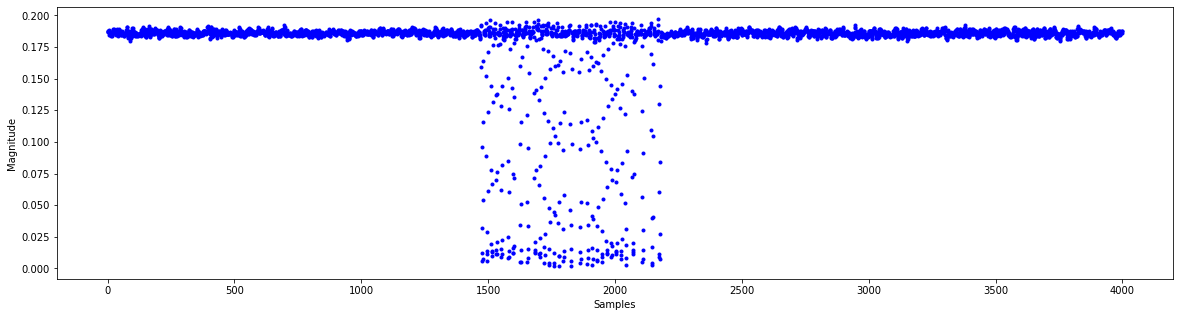

In [64]:
# Plot the magnitude of the signal
plt.plot(complex_to_mag(data[start:end]), 'b.')
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.show()

In [65]:
magnitudes = shift_down(complex_to_mag(data), 0.1)
# Transform our complex data to a list of zeros and ones
binary = binary_slicer(magnitudes)

# Find the artifacts' positions in the array
# (only use the first second of data)
indices, = np.where(binary[0:int(2e6)] == 0)

In [66]:
# Keep only the first sample index per artifact area
first_idx = []
first_idx.append(indices[0])
for i in range(1, len(indices)):
    if (indices[i] - indices[i-1]) > 100:
        first_idx.append(indices[i])

print("Artifacts regions:", first_idx)

Artifacts regions: [68474, 341063, 613733, 887385, 1158945, 1433424, 1707966, 1981578]


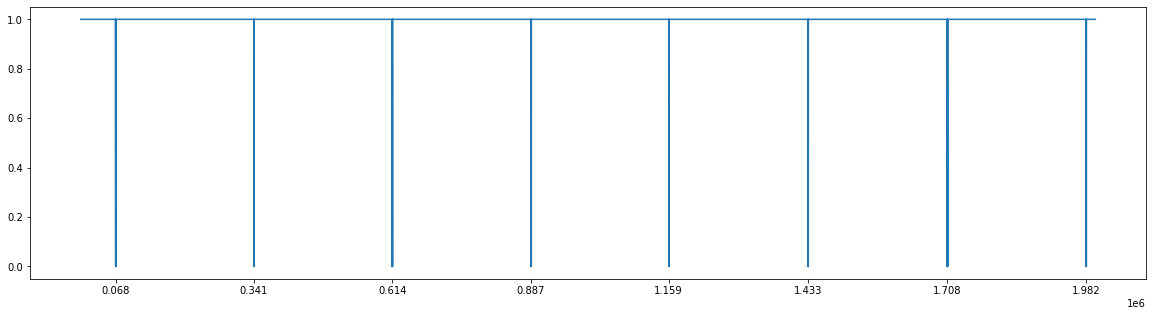

In [67]:
# Plot magnitudes to see artifacts
plt.plot(binary[0:int(2e6)])
plt.xticks(first_idx)
plt.show()

In [68]:
artifacts_period = first_idx[1] - first_idx[0]
period_seconds = artifacts_period / samp_rate

print("Artifacts period in number of samples:", artifacts_period)
print("Artifacts period in seconds:", period_seconds)
print("Number of artifacts per second (freq):", 1 / period_seconds)

Artifacts period in number of samples: 272589
Artifacts period in seconds: 0.1362945
Number of artifacts per second (freq): 7.337053219315526


## Cut the signal into usable chunks

The signal is mostly noise. Let's cut it and keep only parts where data is transmitted.

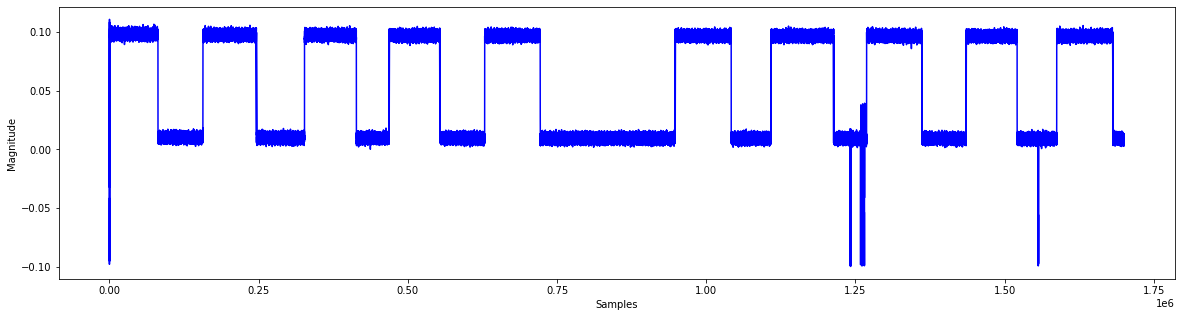

In [69]:
plt.plot(magnitudes[int(3.43e7):int(3.6e7)], 'b-',)
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.show()

## Presentation things

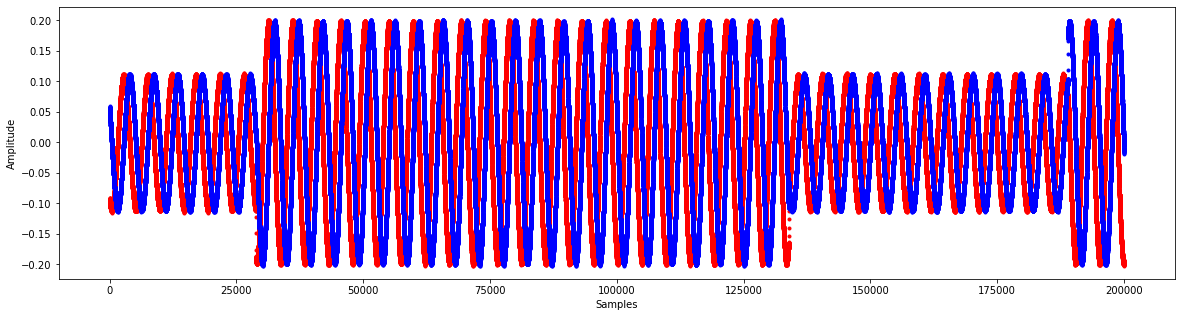

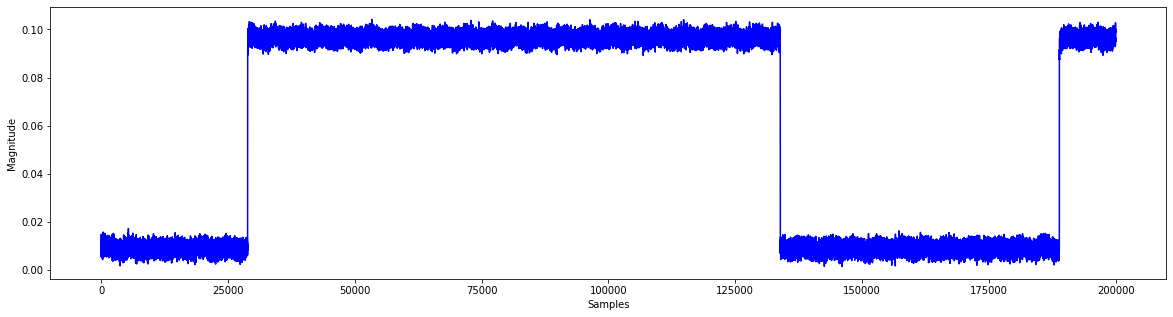

In [17]:
s = int(3.01e7)
e = int(3.03e7)

plt.plot(np.real(data[s:e]), 'r.', np.imag(data[s:e]), 'b.')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

plt.plot(magnitudes[s:e], 'b-',)
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.show()

## From Airspy HF+

In [6]:
datar = np.fromfile(os.path.join(PATH, "test-taoglas-AirspyHF+-2M.nfc"), dtype=scipy.complex64)
data1 = np.fromfile(os.path.join(PATH, "test-tag1.nfc"), dtype=scipy.complex64)
data2 = np.fromfile(os.path.join(PATH, "test-tag2.nfc"), dtype=scipy.complex64)
data3 = np.fromfile(os.path.join(PATH, "test-tag3.nfc"), dtype=scipy.complex64)

magnitudesr = shift_down(complex_to_mag(datar), 0.1)
magnitudes1 = complex_to_mag(data1)
magnitudes2 = complex_to_mag(data2)
magnitudes3 = complex_to_mag(data3)

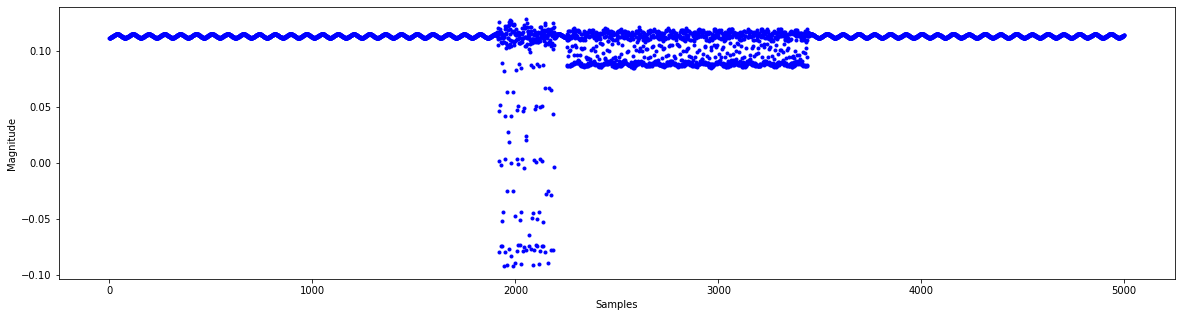

In [18]:
plt.plot(magnitudesr[int(3.095e6):int(3.1e6)], 'b.',)
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.show()

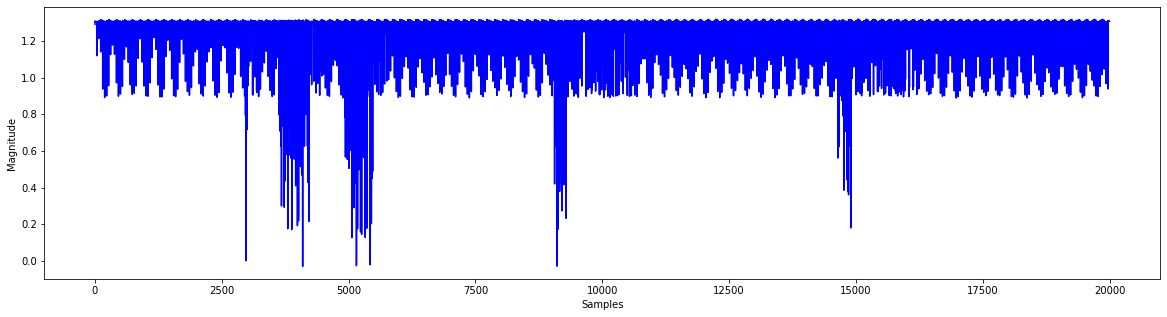

In [24]:
plt.plot(magnitudesr[int(2.73e6):int(2.75e6)], 'b-',)
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.show()

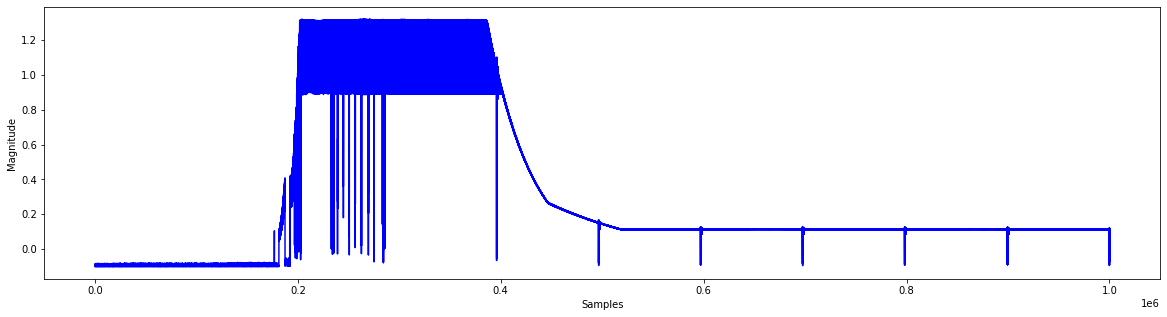

In [39]:
plt.plot(magnitudesr[int(2.5e6):int(3.5e6)], 'b-',)
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.show()

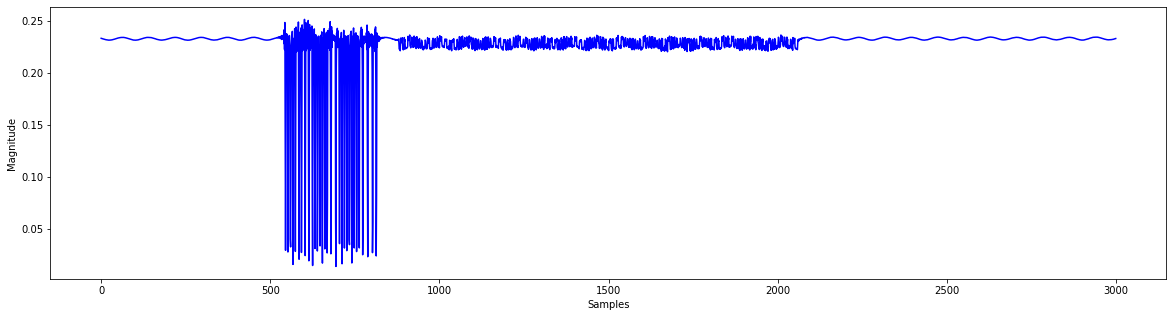

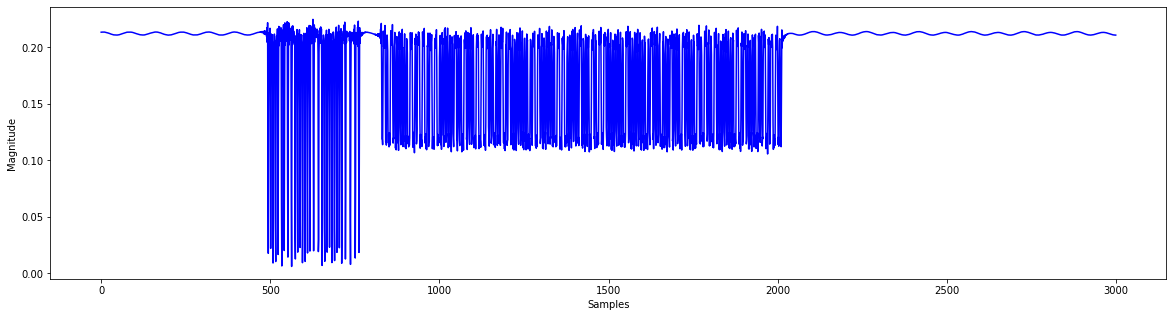

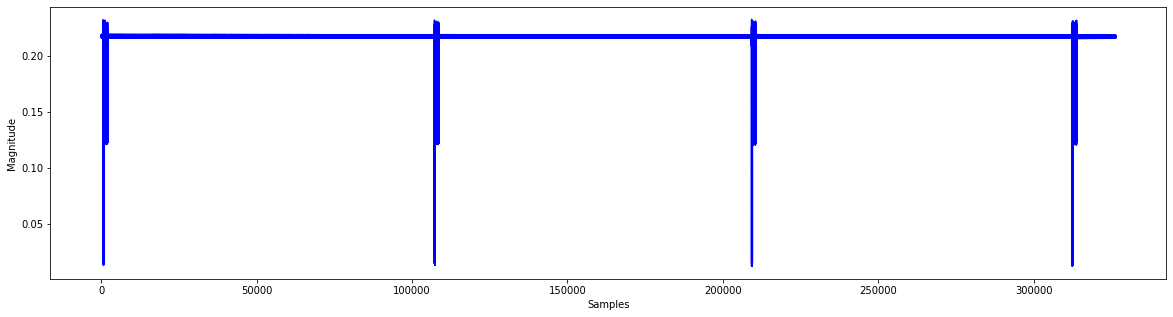

In [26]:
plt.plot(magnitudes3[int(3.58225e6):int(3.58525e6)], 'b-',)
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.show()

plt.plot(magnitudes1[int(4.079e6):int(4.082e6)], 'b-',)
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.show()

plt.plot(magnitudes2[int(3.9236e6):int(4.25e6)], 'b-',)
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.show()

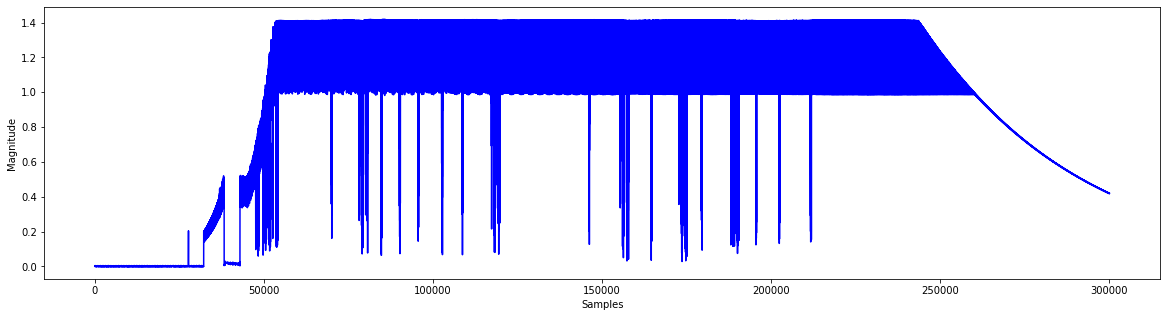

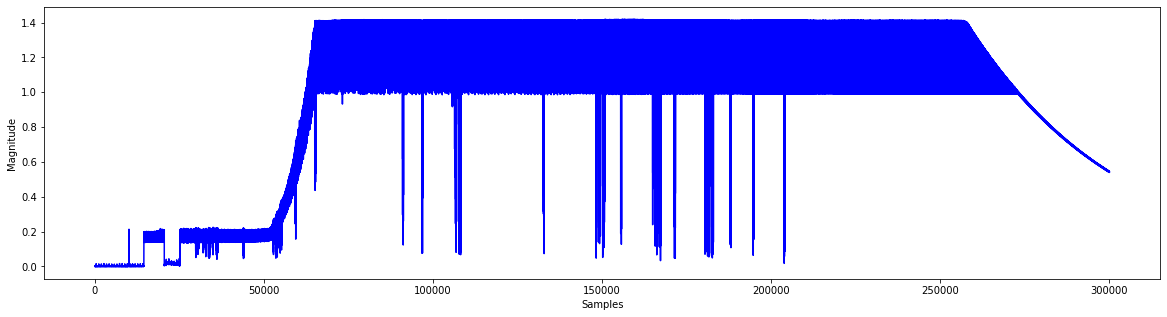

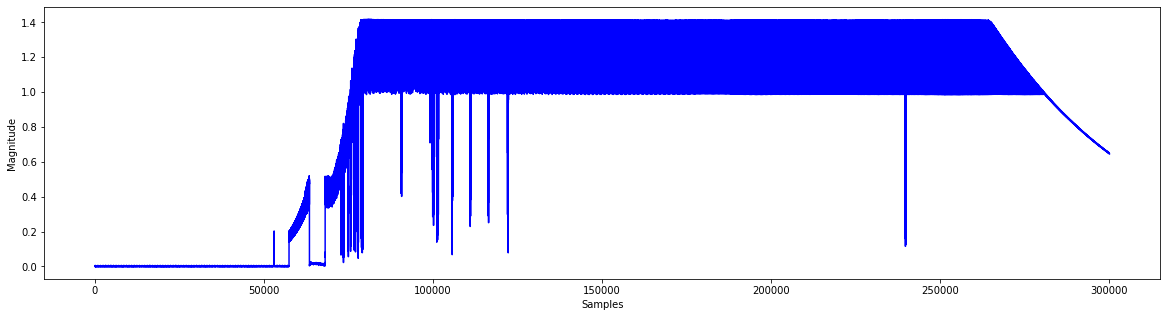

In [8]:
plt.plot(magnitudes3[int(2.75e6):int(3.05e6)], 'b-',)
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.show()

plt.plot(magnitudes1[int(3.57e6):int(3.87e6)], 'b-',)
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.show()

plt.plot(magnitudes2[int(2.15e6):int(2.45e6)], 'b-',)
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.show()

## Continuous wavelet transform

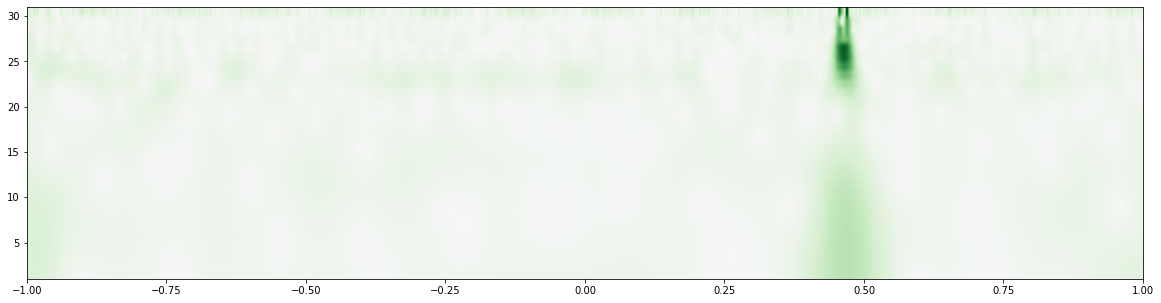

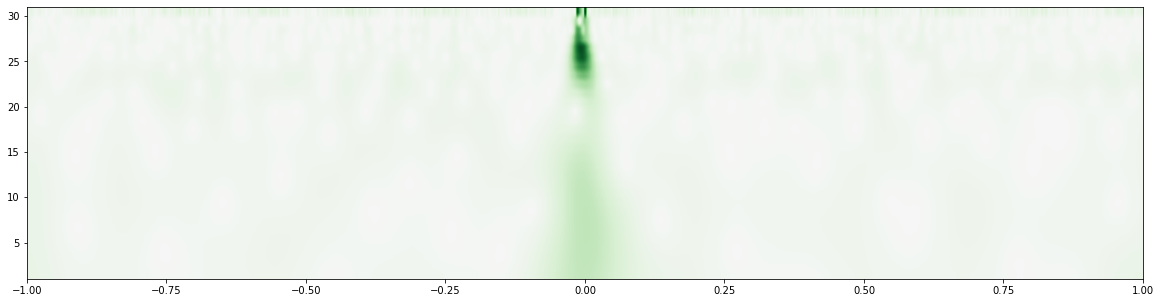

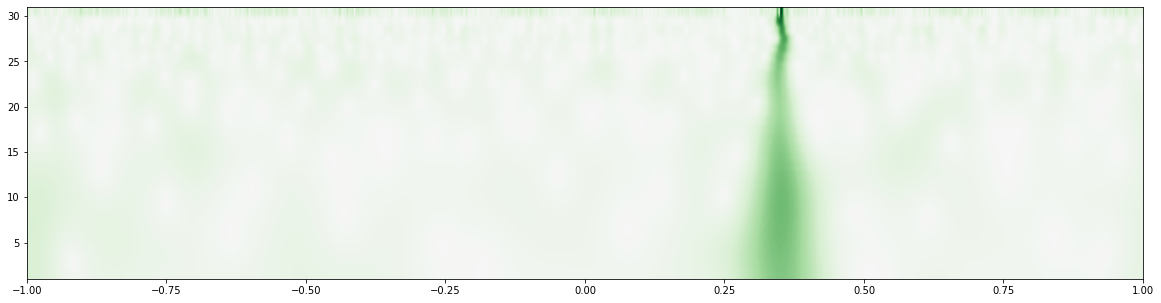

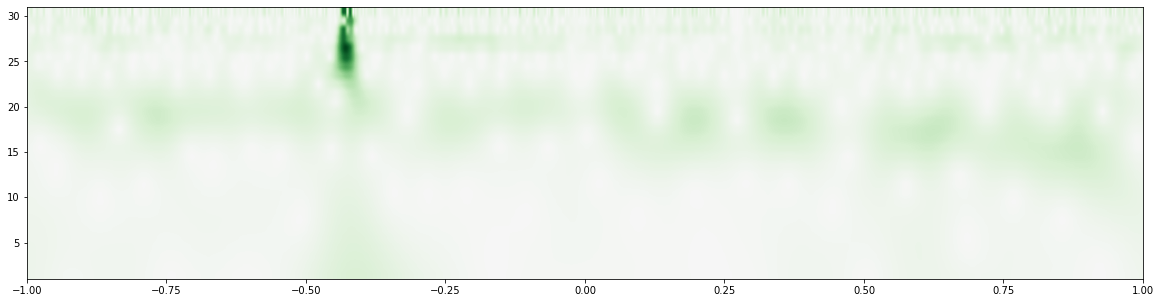

In [41]:
widths = np.arange(1, 31)
cwt = sig.cwt(np.real(signals[0][1][0:int(1000)]), sig.morlet2, widths)
plt.imshow(abs(cwt), extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwt).max(), vmin=-abs(cwt).max())
plt.show()

widths = np.arange(1, 31)
cwt = sig.cwt(np.real(signals[1][1][0:int(1000)]), sig.morlet2, widths)
plt.imshow(abs(cwt), extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwt).max(), vmin=-abs(cwt).max())
plt.show()

widths = np.arange(1, 31)
cwt = sig.cwt(np.real(signals[2][1][0:int(1000)]), sig.morlet2, widths)
plt.imshow(abs(cwt), extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwt).max(), vmin=-abs(cwt).max())
plt.show()

widths = np.arange(1, 31)
cwt = sig.cwt(np.real(signals[3][1][0:int(1000)]), sig.morlet2, widths)
plt.imshow(abs(cwt), extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwt).max(), vmin=-abs(cwt).max())
plt.show()